In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
import re

[ca-ws:1422728] mca_base_component_repository_open: unable to open mca_accelerator_rocm: libamdhip64.so.6: cannot open shared object file: No such file or directory (ignored)


Let's use the same material definition as the existing pincell depletion example 

In [9]:
# Instantiate some Materials and register the appropriate Nuclides
uf4 = openmc.Material(name='UF4')
uf4.set_density('g/cm3', 4.5)
uf4.add_element('U', 1., enrichment=2.4)
uf4.add_element('F', 4.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uf4, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to set up a geometrical reactivity controller, as we shall see in the `msr_pincell_reactivity_control` notebook.    

In [10]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
# set initial borated water level to -59 cm 
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uf4, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
root = openmc.Universe(cells=[fuel, gap, clad, msr])
# Define overall geometry
geometry = openmc.Geometry(root)

In [11]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.IndependentSource(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

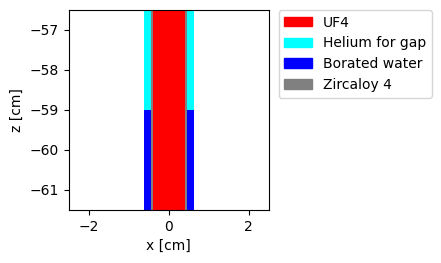

In [12]:
# Create plot
colors = {uf4:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
root.plot(width=(5, 5), origin=(0,0,-59), pixels=(200, 200), basis='xz', color_by='material', colors=colors, legend=True)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with MSR capabilities:

In [13]:
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
uf4.volume = pi * fuel_or.r**2 * height
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 1.0e5  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading O16 from /home/lorenzo/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzo/nuclear_data/endfb80_hdf5/O17.h5
 Reading O18 from /home/lorenzo/nuclear_data/endfb80_hdf5/O18.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/end

 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Pu239 from /home/lorenzo/nuclear_data/endfb80_hdf5/Pu239.h5
 Maximum neutron transport energy: 20000000 eV for F19
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.55230
        2/1    0.71581
        3/1    0.84742
        4/1    0.82083
        5/1    0.88937
        6/1    0.83661
        7/1    0.90388
        8/1    0.89892
        9/1    0.84564
       10/1    0.89387
       11/1    0.81112
       12/1    0.90903    0.86007 +/- 0.04896
       13/1    0.82243    0.84752 +/- 0.03093
       14/1    0.87888    0.85536 +/- 0.02323
       15/1    0.85114    0.85452 +/- 0.01801
       16/1    0.88721    0.85997 +/- 0.01569
       17/1    0.88177    0.86308 +/- 0.01362
       18/1    0.90888    0.86881 +/- 0.01311
       19/1    0.83572    0.86513

Let's store the results for later comparison

In [14]:
# Open results file
ref_results = openmc.deplete.Results("depletion_results.h5")


UF4 (assuming oxidation state of Uranium +4) frees 4 atoms of fluorine every time a fission event occurs, which will then bind with fission products with lower oxidation states than uranium, giving rise to an excess of free fluorine atoms and thus increasing the redox potential of the salt.  On the other hand, neutron capture reactions, will likely increase the oxidation state of the transmuting nuclide, thus creating a deficiency of fluorine atoms and reducing the redox potential of the salt.  
Assuming the oxidation states of the nuclides present in the salt are known, the redox can be computed multiplying the number of atoms $N_i$ of each nuclide present in the salt, by their oxidation states $Ox_i$:

\begin{equation}
\sum_i N_i Ox_i
\end{equation}


The added term for a generic buffer nuclide can be expressed mathematically  as: 

\begin{equation}
\frac{dN_b(t)}{dt} = \cdots + \frac{1}{Ox_b}\sum_i N_i\left( L_{ii}Ox_i - \sum_j G_{i\rightarrow j } Ox_j\right)
\end{equation}

where `Ox_b` is the oxidation state of the buffer nuclide, and `Ox_i`, `Ox_j` are the oxidation states of the i-th nuclide undergoing a reaction or a decay and of the j-th product nuclide, respectively.
Therefore, the first term in the right hand side represents the losses of the i-th nuclide (i.e. the diagonal terms of the Bateman matrix), and the second term the gains of the j-th nuclides (i.e. the off-diagonal terms of the Bateman matrix).

To add a redox control to out fuel material, we have to add the `add_redox` method to an integrator instance, specifying the material to where add the routine, the nuclides buffer vector and a set of oxidation states. 

In [15]:
# We need to re-instanciate the operator and the integrator 
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')

# my guess of oxidation states 
ox = {
    'H': +1, 'He': 0, 'Li': +1, 'Be': +2, 'B': +3,  'C': 0,   'N': +3, 'O': -2,
    'F': -1, 'Ne': 0, 'Na': +1, 'Mg': +2, 'Al': +3, 'Si': +4, 'P': -3, 'S': -2,
    'Cl':-1, 'Ar': 0, 'K':  +1, 'Ca': +2, 'Sc': +3, 'Ti': +4, 'V': +5, 'Cr':+3,
    'Mn':+2, 'Fe':+3, 'Co': +2, 'Ni': +2, 'Cu': +2, 'Zn': +2, 'Ga':+3, 'Ge':+2,
    'As':+3, 'Se':-2, 'Br': -1, 'Kr':  0, 'Rb': +1, 'Sr': +2, 'Y': +3, 'Zr':+4,
    'Nb':+6, 'Mo':+4, 'Tc': +4, 'Ru': +2, 'Rh': +3, 'Pd': +2, 'Ag':+1, 'Cd':+2,
    'In':+3, 'Sn':+2, 'Sb': +3, 'Te': +2, 'I':  -1, 'Xe':  0, 'Cs':+1, 'Ba':+2,
    'La':+3, 'Ce':+3, 'Pr': +3, 'Nd': +3, 'Pm': +3, 'Sm': +3, 'Eu':+3, 'Gd':+3,
    'Tb':+3, 'Dy':+3, 'Ho': +3, 'Er': +3, 'Tm': +3, 'Yb': +3, 'Lu':+3, 'Hf':+4,
    'Ta':+5, 'W': +4, 'Re': +4, 'Os': +4, 'Ir': +3, 'Pt': +2, 'Au':+3, 'Hg':+1,
    'Tl':+1, 'Pb':+2, 'Bi': +3, 'Po': +2, 'At': -1, 'Rn':  0, 'Fr':+1, 'Ra':+2,
    'Ac':+2, 'Th':+4, 'Pa': +4, 'U':  +4, 'Np': +4, 'Pu': +3, 'Am':+3, 'Cm':+3,
    'Bk':+3, 'Cf':+3, 'Es': +3, 'Fm': +3, 'Md': +3, 'No': +2, 'Lr':+3
    }

# Add transfer rates for main absorbers to maintain an almost constant burnup 
integrator.add_transfer_rate(uf4, ['Xe', 'Kr'], 0.1)
# Use U238 as buffer for redox control
integrator.add_redox(uf4, {'U238':1}, ox)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading O16 from /home/lorenzo/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzo/nuclear_data/endfb80_hdf5/O17.h5
 Reading O18 from /home/lorenzo/nuclear_data/endfb80_hdf5/O18.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/end

 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Pu239 from /home/lorenzo/nuclear_data/endfb80_hdf5/Pu239.h5
 Maximum neutron transport energy: 20000000 eV for F19
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.55230
        2/1    0.71581
        3/1    0.84742
        4/1    0.82083
        5/1    0.88937
        6/1    0.83661
        7/1    0.90388
        8/1    0.89892
        9/1    0.84564
       10/1    0.89387
       11/1    0.81112
       12/1    0.90903    0.86007 +/- 0.04896
       13/1    0.82243    0.84752 +/- 0.03093
       14/1    0.87888    0.85536 +/- 0.02323
       15/1    0.85114    0.85452 +/- 0.01801
       16/1    0.88721    0.85997 +/- 0.01569
       17/1    0.88177    0.86308 +/- 0.01362
       18/1    0.90888    0.86881 +/- 0.01311
       19/1    0.83572    0.86513

       52/1    0.99612    0.99609 +/- 0.00534
       53/1    1.03349    0.99696 +/- 0.00529
       54/1    1.00859    0.99723 +/- 0.00517
       55/1    1.01775    0.99768 +/- 0.00508
       56/1    0.92832    0.99617 +/- 0.00519
       57/1    0.93116    0.99479 +/- 0.00526
       58/1    1.02899    0.99550 +/- 0.00520
       59/1    0.99388    0.99547 +/- 0.00509
       60/1    1.03489    0.99626 +/- 0.00505
       61/1    0.97515    0.99584 +/- 0.00497
       62/1    0.98673    0.99567 +/- 0.00488
       63/1    0.93810    0.99458 +/- 0.00491
       64/1    1.03245    0.99528 +/- 0.00487
       65/1    0.98606    0.99512 +/- 0.00478
       66/1    1.00775    0.99534 +/- 0.00470
       67/1    0.96381    0.99479 +/- 0.00465
       68/1    1.13116    0.99714 +/- 0.00514
       69/1    0.99263    0.99706 +/- 0.00505
       70/1    1.06626    0.99822 +/- 0.00510
       71/1    0.94620    0.99736 +/- 0.00508
       72/1    0.97634    0.99703 +/- 0.00501
       73/1    1.04282    0.99775 

We can now compute the redox in the two cases:

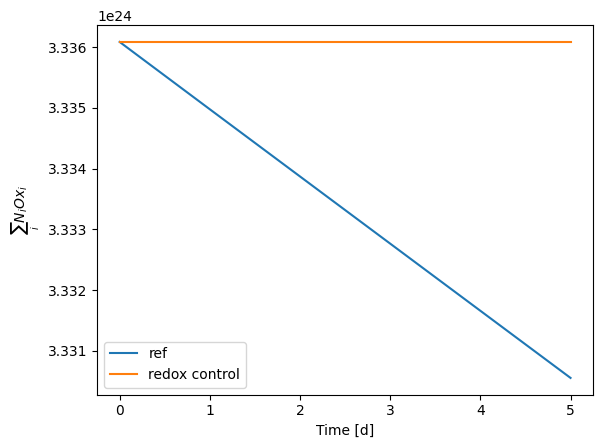

In [38]:
results = openmc.deplete.Results("depletion_results.h5")

ref_redox = np.zeros(len(results))
redox = np.zeros(len(results))

for nuc in results[0].index_nuc:
    ox_nuc = ox[re.split(r'\d+', nuc)[0]]
    ref_redox += ox_nuc*ref_results.get_atoms('1',nuc)[1]
    redox += ox_nuc*results.get_atoms('1',nuc)[1]

plt.plot(ref_redox, label='ref')
plt.plot(redox, label='redox control')
plt.xlabel('Time [d]')
plt.ylabel(r'$\sum_iN_iOx_i$')
plt.legend()
plt.show() 

As we can notice, in the second case the initial redox is kept constant by addition of buffer nuclide U238 that compensate the increase of fluorine atoms in the fuel salt:

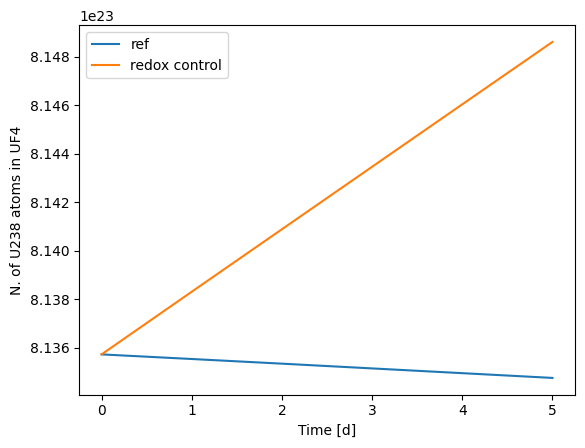

In [42]:
plt.plot(ref_results.get_atoms('1', 'U238')[1], label='ref')
plt.plot(results.get_atoms('1', 'U238')[1], label='redox control')
plt.xlabel('Time [d]')
plt.ylabel('N. of U238 atoms in UF4')
plt.legend()
plt.show() 